In [1]:
!nvidia-smi

Sat Aug 30 04:20:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!wget -O /content/data.zip https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/candy_data_06JAN25.zip

--2025-08-30 04:21:42--  https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/candy_data_06JAN25.zip
Resolving s3.us-west-1.amazonaws.com (s3.us-west-1.amazonaws.com)... 16.15.0.30, 16.15.4.192, 16.15.4.45, ...
Connecting to s3.us-west-1.amazonaws.com (s3.us-west-1.amazonaws.com)|16.15.0.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45172966 (43M) [application/zip]
Saving to: ‘/content/data.zip’

/content/data.zip   100%[===================>]  43.08M  12.9MB/s    in 3.3s    

2025-08-30 04:21:46 (12.9 MB/s) - ‘/content/data.zip’ saved [45172966/45172966]



In [3]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

In [4]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9


--2025-08-30 04:22:33--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-08-30 04:22:33 (46.6 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 162
Number of annotation files: 162
Images moving to train: 145
Images moving to validation: 17


In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.7 MB/s eta 0:00:00


In [6]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 11
names:
- MMs_peanut
- MMs_regular
- airheads
- gummy_worms
- milky_way
- nerds
- skittles
- snickers
- starbust
- three_musketeers
- twizzlers


In [7]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_widt

In [8]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,417,057 parameters, 0 gradients, 21.3 GFLOPs

image 1/17 /content/data/validation/images/0b8dff73-candy_130.jpg: 384x640 1 gummy_worms, 1 twizzlers, 57.2ms
image 2/17 /content/data/validation/images/5251ce1a-candy_155.jpg: 384x640 1 starbust, 10.9ms
image 3/17 /content/data/validation/images/63b1fca9-candy_2.jpg: 384x640 2 MMs_peanuts, 2 airheadss, 1 starbust, 10.9ms
image 4/17 /content/data/validation/images/7058d4d5-candy_102.jpg: 480x640 1 MMs_peanut, 1 MMs_regular, 1 airheads, 1 gummy_worms, 1 milky_way, 1 twizzlers, 54.5ms
image 5/17 /content/data/validation/images/73a058b9-candy_143.jpg: 384x640 1 milky_way, 11.5ms
image 6/17 /content/data/validation/images/79241d26-candy_10.jpg: 384x640 1 MMs_peanut, 1 airheads, 1 snickers, 1 starbust, 10.8ms
image 7/17 /content/data/validation/images/84892ac0-candy_122.jpg: 384x640 1 airheads, 10.8ms
image 8/17 /content/data

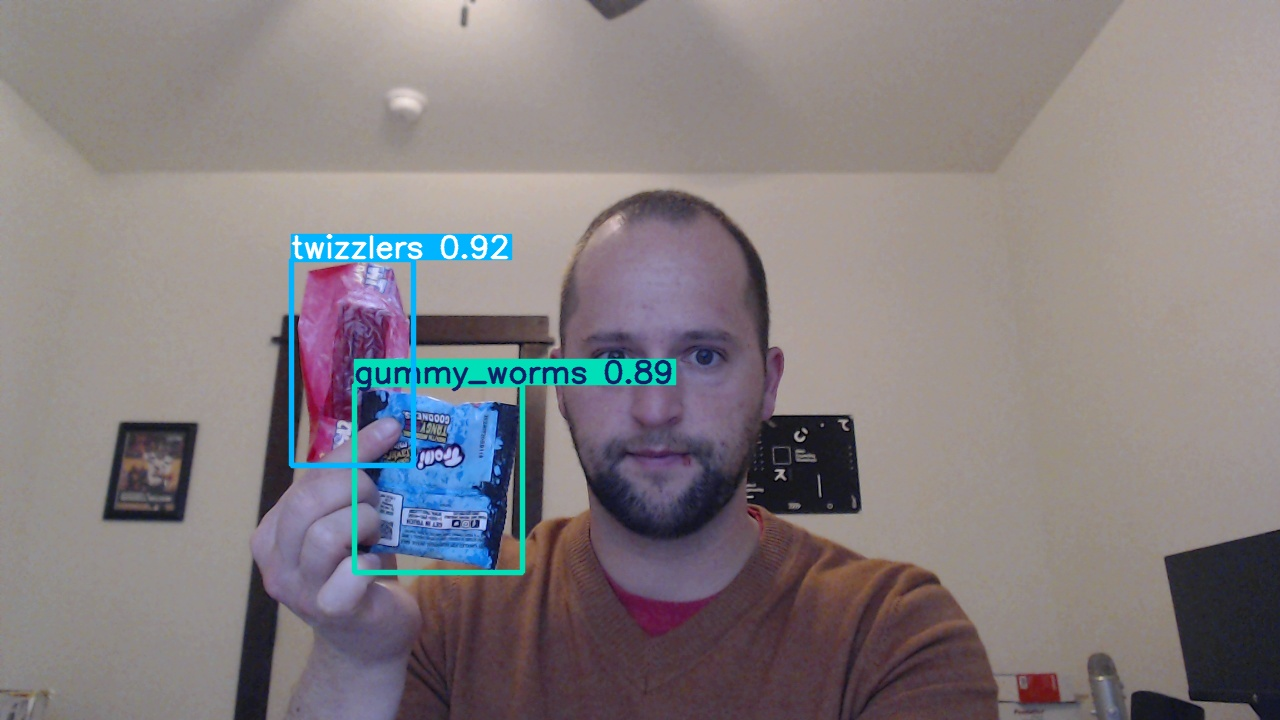

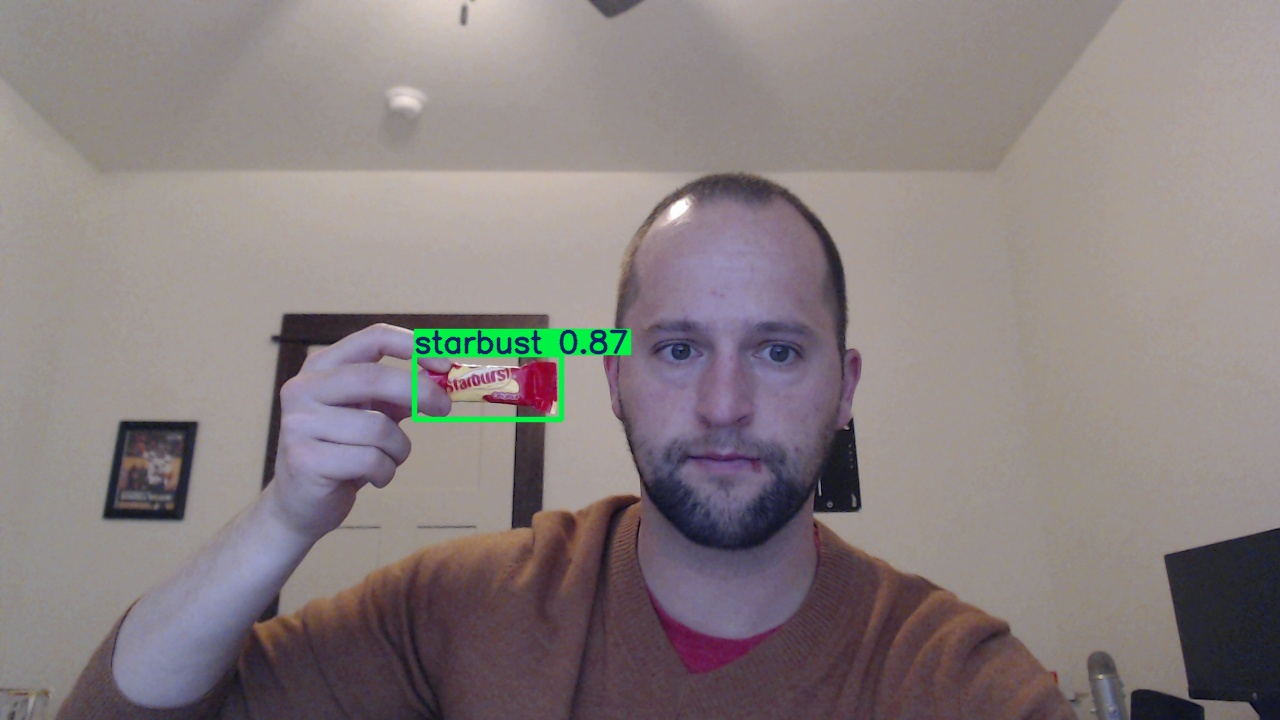

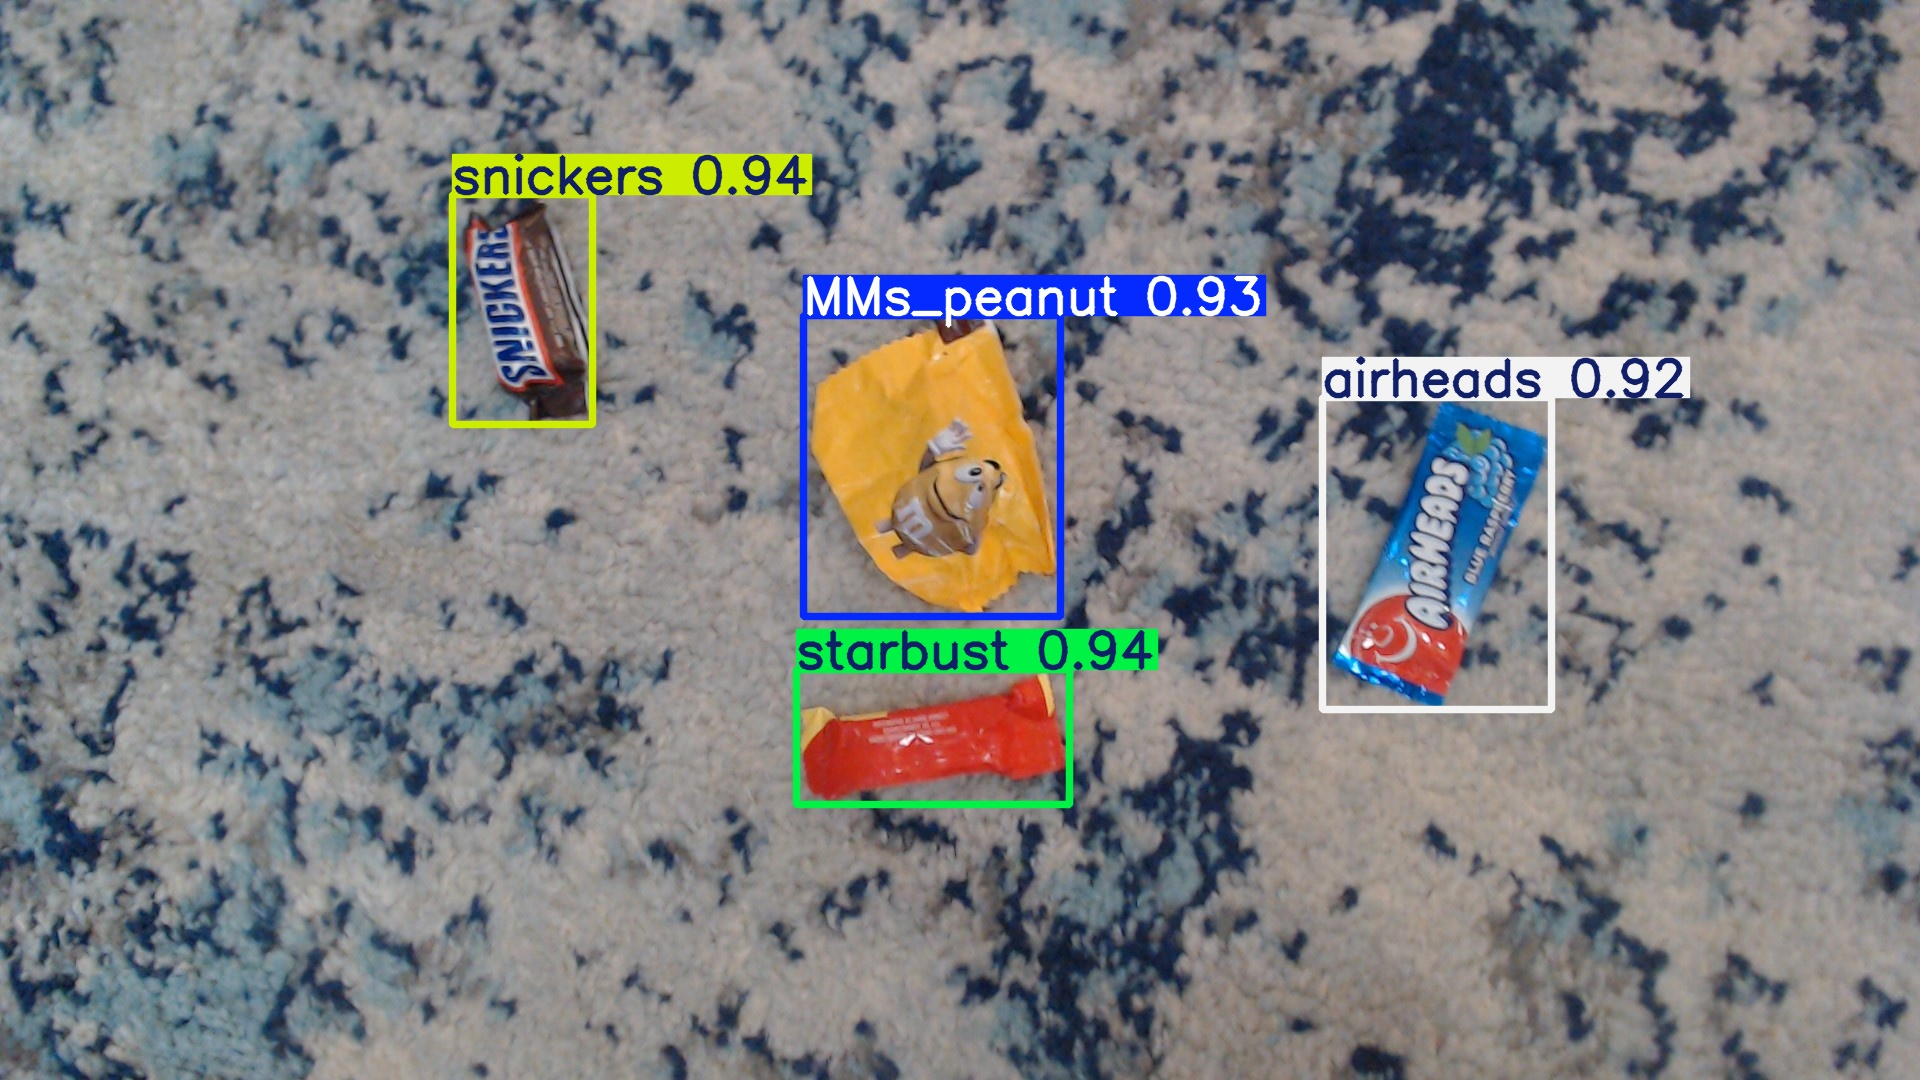

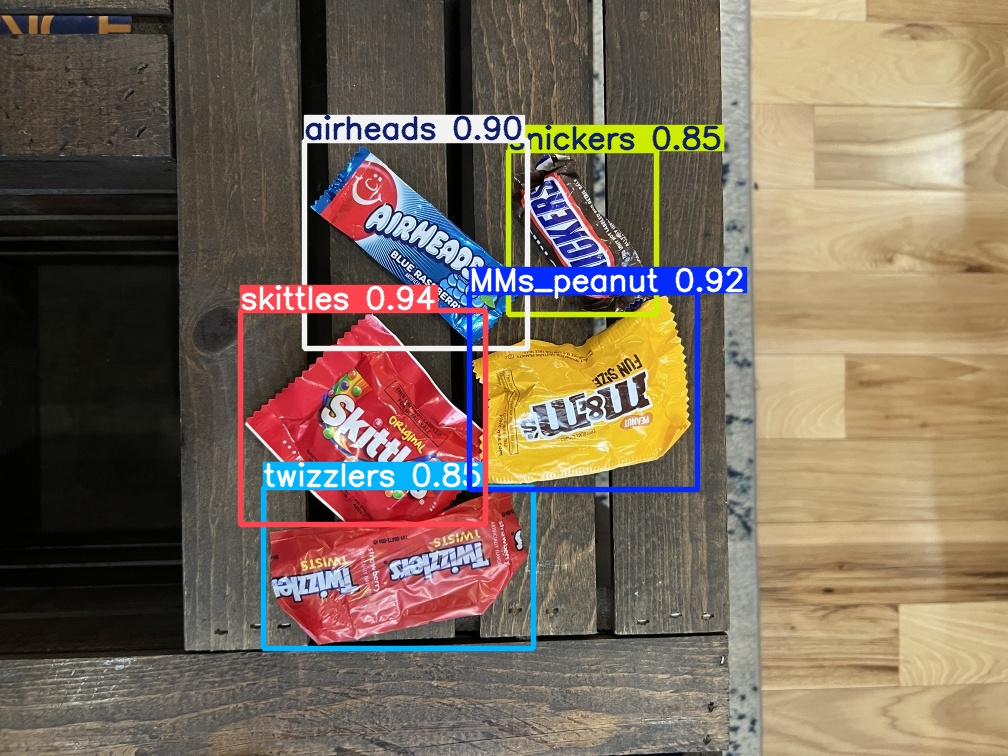

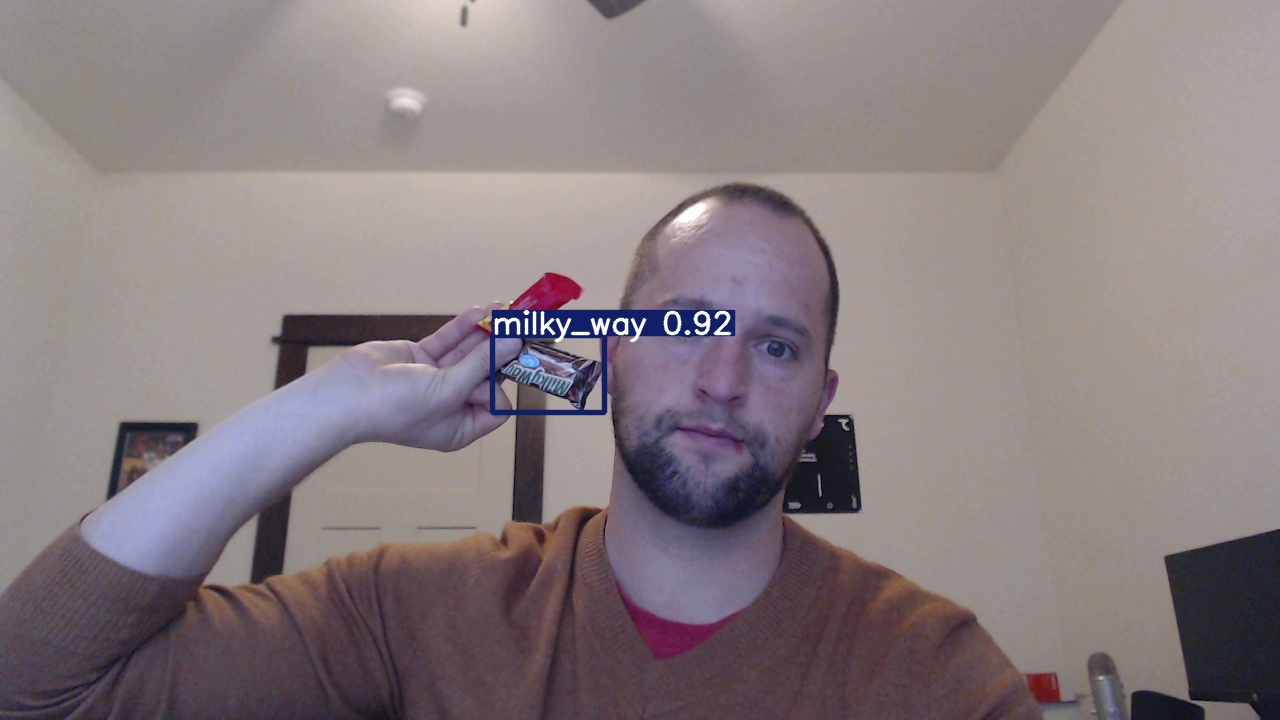

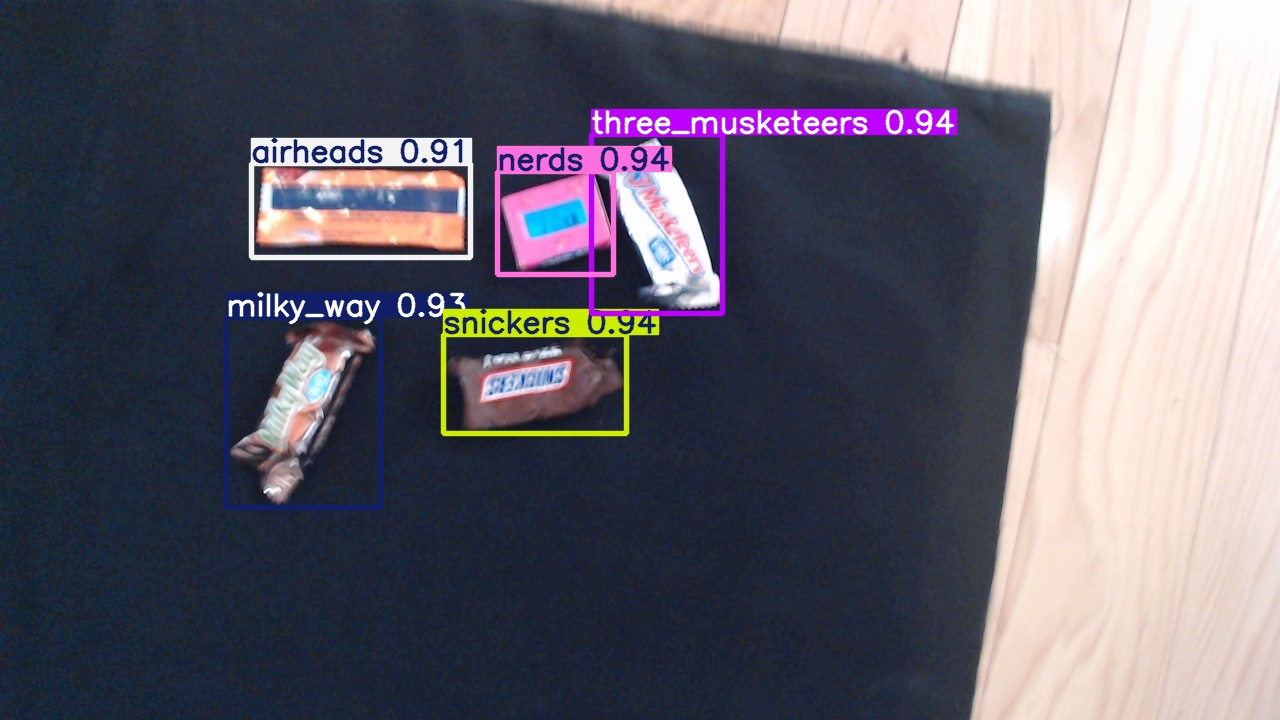

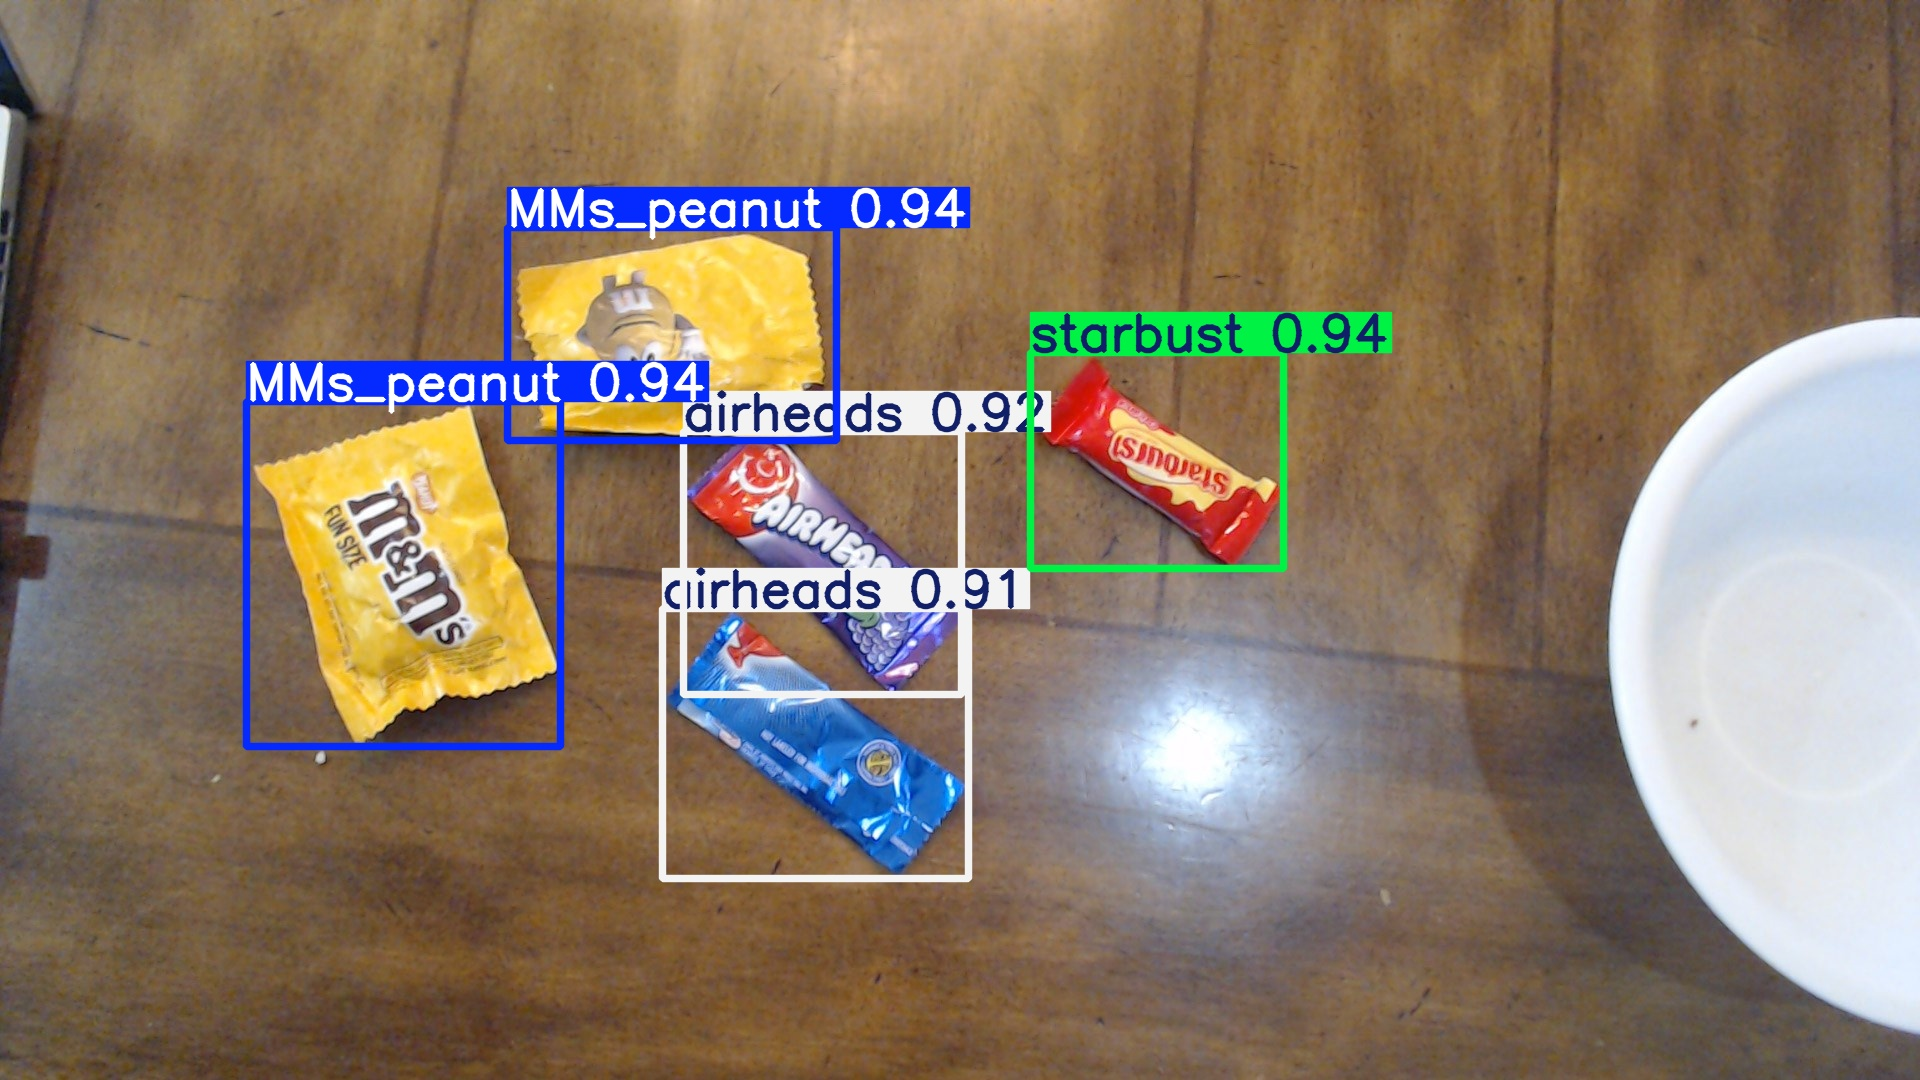

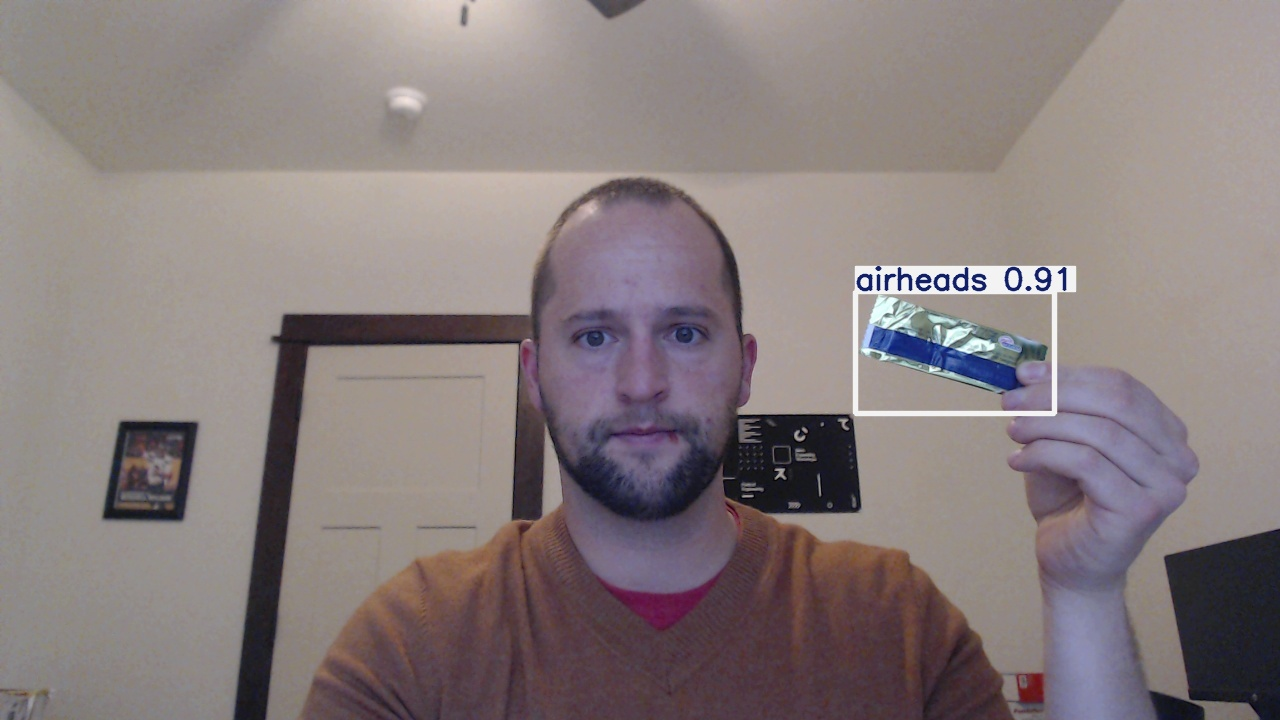

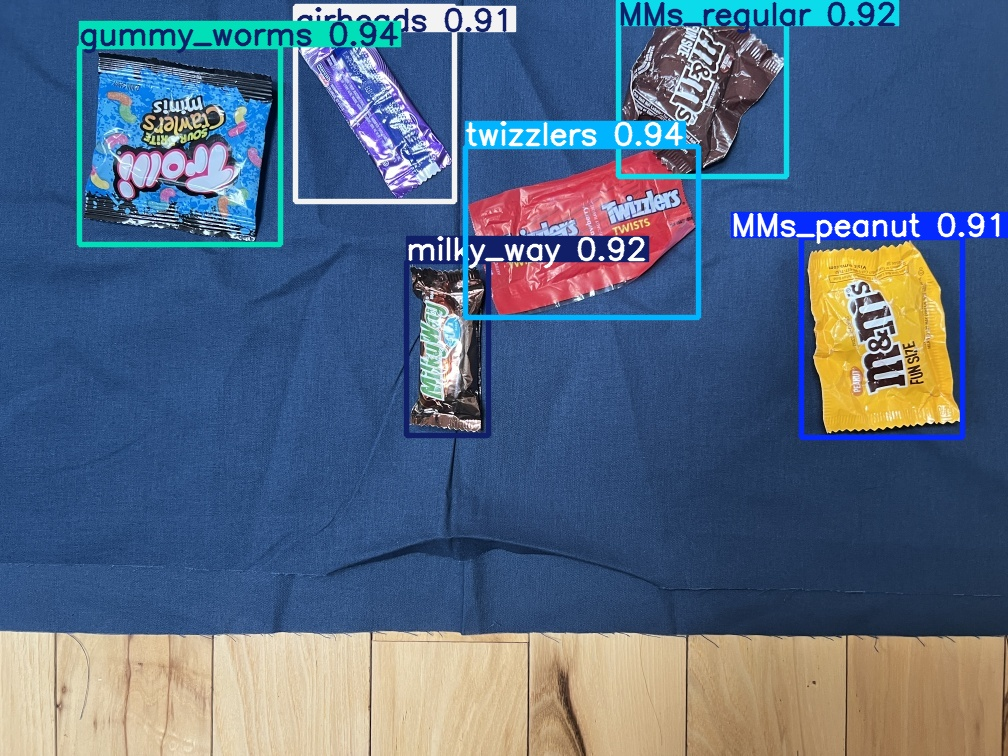

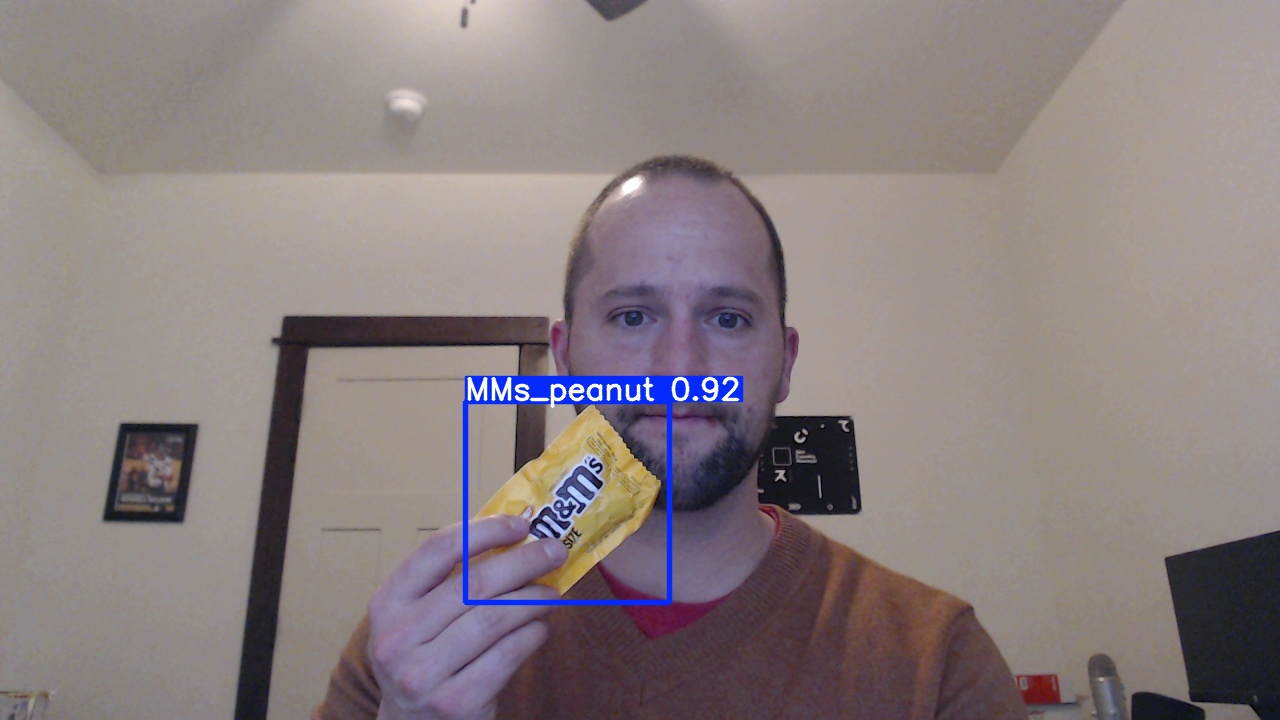

In [9]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')